<a href="https://colab.research.google.com/github/bsundar937/GAN_stability/blob/main/GAN_bimodal_1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt



# model params
batch_size = 64
latent_dim = 200
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 8

# training params
n_epochs = 200
n_samples = 10000
m1 = -2
s1 = 1
m2 = 2
s2 = 1
w1 = 0.5


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 64),
            nn.Tanh()
        )

    def forward(self, z):
        z = self.model(z)
        return z


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc = nn.Linear(batch_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


class DataDistribution():
  def __init__(self, m1, s1, m2, s2, w1):
    self.m1 = m1
    self.m2 = m2
    self.s1 = s1
    self.s2 = s2
    self.w1 = w1

  def sample(self, n_samples):
    mode = np.random.choice([0, 1], size=n_samples, p=[self.w1, 1 - self.w1])
    samples1 = np.random.normal(self.m1, self.s1, size=np.sum(mode == 0))
    samples2 = np.random.normal(self.m2, self.s2, size=np.sum(mode == 1))

    samples = np.concatenate([samples1, samples2])

    return samples



# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

cuda = True if torch.cuda.is_available() else False

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr = lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr = lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------


def train_gan(generator, discriminator, n_epochs, batch_size, latent_dim):
  distr = DataDistribution(m1, s1, m2, s2, w1)

  for epoch in range(n_epochs):
    for i in range(batch_size):
      real_labels = torch.ones(batch_size, 1)
      fake_labels = torch.zeros(batch_size, 1)


      real_samples = torch.Tensor(distr.sample(batch_size))

      print(real_samples.shape)
      print(real_labels.shape)

      # training generator
      optimizer_G.zero_grad()

      z = torch.randn(batch_size, latent_dim)
      fake_samples = generator(z)

      g_loss = adversarial_loss(discriminator(fake_samples), real_labels)

      g_loss.backward()
      optimizer_G.step()

      # training discriminator
      optimizer_D.zero_grad()

      # Measure discriminator's ability to classify real from generated samples
      real_loss = adversarial_loss(discriminator(real_samples), real_labels)
      fake_loss = adversarial_loss(discriminator(fake_samples.detach()), fake_labels)
      d_loss = (real_loss + fake_loss) / 2

      d_loss.backward()
      optimizer_D.step()


train_gan(generator, discriminator, n_epochs, batch_size, latent_dim)
test_noise = torch.randn(batch_size, latent_dim)

test_samples = generator(test_noise)

plt.hist(test_samples)
plt.show()



# what is in_feat? out_feat? latent_dim?, what should the size of test_noise be

# visualizations of loss function, KL divergence plots


torch.Size([64])
torch.Size([64, 1])


ValueError: ignored

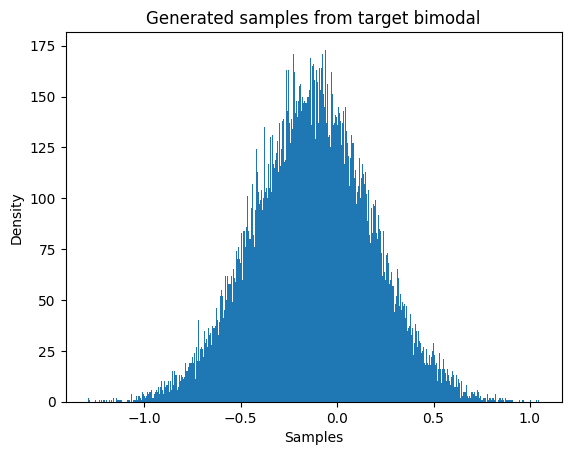

In [49]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)


# model params
lr = 0.001
num_epochs = 20000
batch_size = 64
input_size = 1
hidden_size = 16
output_size = 1

# distribution parameters
mean1 = 2
std1 = 1
mean2 = -2
std2 = 1
w1 = 0.5


# generator
class Generator(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(in_feat, out_feat),
            nn.BatchNorm1d(out_feat, 0.8),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        x = self.model(x)
        return x

# discriminator
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.model(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator(input_size, output_size).to(device)
discriminator = Discriminator(input_size).to(device)

# loss/optimizers
loss_function = nn.BCELoss()
generator_optimizer = optim.Adam(generator.parameters(), lr=lr)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr)

# Generate samples from bimodal

def generate_samples(n_samples):
    mode = np.random.choice([0, 1], size=n_samples, p=[w1, 1 - w1])
    samples1 = np.random.normal(mean1, std1, size=np.sum(mode == 0))
    samples2 = np.random.normal(mean2, std2, size=np.sum(mode == 1))
    samples = np.concatenate([samples1, samples2]).reshape((64,1))
    return samples

# Training loop
for epoch in range(num_epochs):
    # Generate real and fake samples
    real_samples = torch.Tensor(generate_samples(batch_size)).to(device)

    fake_samples = generator(torch.randn(batch_size, input_size).to(device))

    discriminator_optimizer.zero_grad()

    real_labels = torch.ones(batch_size, 1).to(device)
    real_predictions = discriminator(real_samples)
    real_loss = loss_function(real_predictions, real_labels)

    fake_labels = torch.zeros(batch_size, 1).to(device)
    fake_predictions = discriminator(fake_samples)
    fake_loss = loss_function(fake_predictions, fake_labels)

    discriminator_loss = real_loss + fake_loss
    discriminator_loss.backward()
    discriminator_optimizer.step()

    generator_optimizer.zero_grad()

    fake_samples = generator(torch.randn(batch_size, input_size).to(device))
    fake_predictions = discriminator(fake_samples)
    generator_loss = loss_function(fake_predictions, real_labels)

    # generator weights
    generator_loss.backward()
    generator_optimizer.step()


# Generate samples from the learned distribution
num_samples = 25000
with torch.no_grad():
    noise = torch.randn(num_samples, input_size).to(device)
    generated_samples = generator(noise).cpu().numpy()

# visualize
plt.hist(generated_samples, bins=500)
plt.xlabel('Samples')
plt.ylabel('Density')
plt.title('Generated samples from target bimodal')
plt.show()